# 時系列データをトレンド・季節/周期性・残差に分解する

In [1]:
# Google　Colaboratory で実行する場合はインストールする
if "google.colab" in str(get_ipython()):
    !pip install japanize_matplotlib
    !pip install seaborn
    !pip install statsmodels

In [2]:
import japanize_matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

In [3]:
import os

if os.path.exists("../../stylesheet/k_dm.mplstyle"):
    plt.style.use("../../stylesheet/k_dm.mplstyle")

## サンプルデータを作成
周期的な数値を複数組合せ、さらに区分的にトレンドが変化しています。また `np.random.rand()` でノイズも乗せています。

In [4]:
date_list = pd.date_range("2021-01-01", periods=365, freq="D")
value_list = [
    10
    + i % 14
    + np.log(1 + i % 28 + np.random.rand())
    + np.sqrt(1 + i % 7 + np.random.rand()) * 2
    + (((i - 100) / 10)) * (i > 100)
    - ((i - 200) / 7) * (i > 200)
    + np.random.rand()
    for i, di in enumerate(date_list)
]

df = pd.DataFrame(
    {
        "日付": date_list,
        "観測値": value_list,
    }
)

df.head(10)

,日付,観測値
0,2021-01-01,13.874478
1,2021-01-02,15.337944
2,2021-01-03,17.166133
3,2021-01-04,19.561274
4,2021-01-05,20.426502
5,2021-01-06,22.127725
6,2021-01-07,24.484329
7,2021-01-08,22.313675
8,2021-01-09,23.716303
9,2021-01-10,25.861587


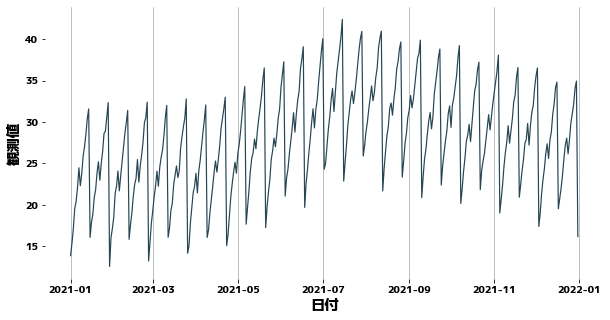

In [5]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df["日付"], y=df["観測値"])
plt.grid(axis="x")
plt.show()

# トレンド・季節/周期性・残差に分解する
[statsmodels.tsa.seasonal.STL](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html)を用いて時系列データを

- トレンド(.trend)
- 季節/周期性(.seasonal)
- 残差(.resid)

に分解してみます。（以下のコード中のdrは[DecomposeResult](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.DecomposeResult.html#statsmodels.tsa.seasonal.DecomposeResult)を指しています。）

参考文献：Cleveland, Robert B., et al. "STL: A seasonal-trend decomposition." J. Off. Stat 6.1 (1990): 3-73. ([pdf](http://www.nniiem.ru/file/news/2016/stl-statistical-model.pdf))

In [6]:
period = 28
stl = STL(df["観測値"], period=period)
dr = stl.fit()

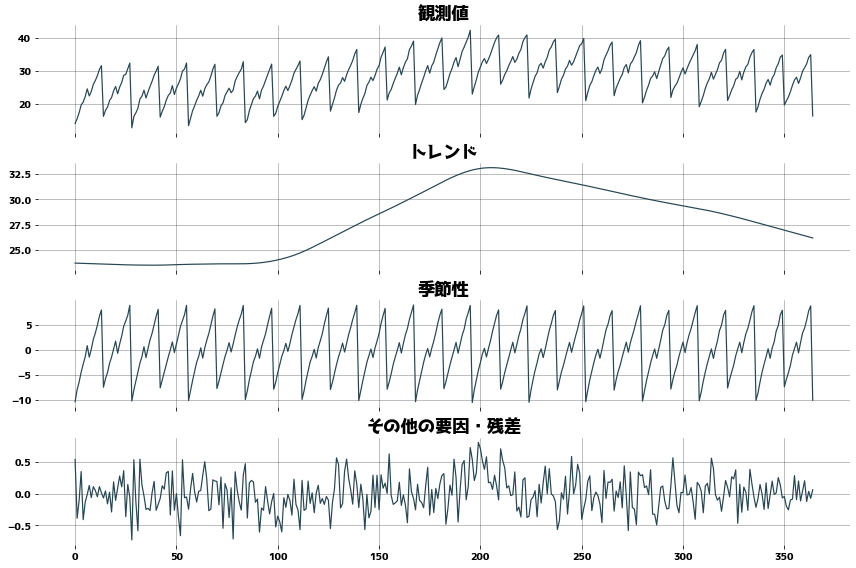

In [7]:
_, axes = plt.subplots(figsize=(12, 8), ncols=1, nrows=4, sharex=True)

axes[0].set_title("観測値")
axes[0].plot(dr.observed)
axes[0].grid()

axes[1].set_title("トレンド")
axes[1].plot(dr.trend)
axes[1].grid()

axes[2].set_title("季節性")
axes[2].plot(dr.seasonal)
axes[2].grid()

axes[3].set_title("その他の要因・残差")
axes[3].plot(dr.resid)
axes[3].grid()

plt.tight_layout()
plt.show()

### 外れ値に強いか確認

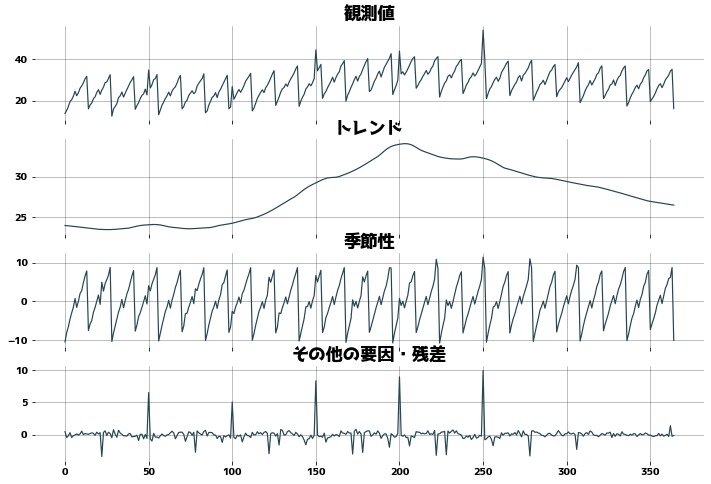

In [8]:
def check_outlier():
    period = 28
    df_outlier = df["観測値"].copy()

    for i in range(1, 6):
        df_outlier[i * 50] = df_outlier[i * 50] * 1.4

    stl = STL(df_outlier, period=period, trend=31)
    dr_outlier = stl.fit()

    _, axes = plt.subplots(figsize=(12, 8), ncols=1, nrows=4, sharex=True)

    axes[0].set_title("観測値")
    axes[0].plot(dr_outlier.observed)
    axes[0].grid()

    axes[1].set_title("トレンド")
    axes[1].plot(dr_outlier.trend)
    axes[1].grid()

    axes[2].set_title("季節性")
    axes[2].plot(dr_outlier.seasonal)
    axes[2].grid()

    axes[3].set_title("その他の要因・残差")
    axes[3].plot(dr_outlier.resid)
    axes[3].grid()


check_outlier()

# トレンドを捉えることができているか確認する
もしもトレンドが正しく抽出できている場合は、トレンドに周期的な要素が含まれていないはずであり、PACF（偏自己相関）が０に近くなるはずです。

- [statsmodels.tsa.stattools.acf](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html)
- [statsmodels.tsa.stattools.pacf](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.pacf.html)

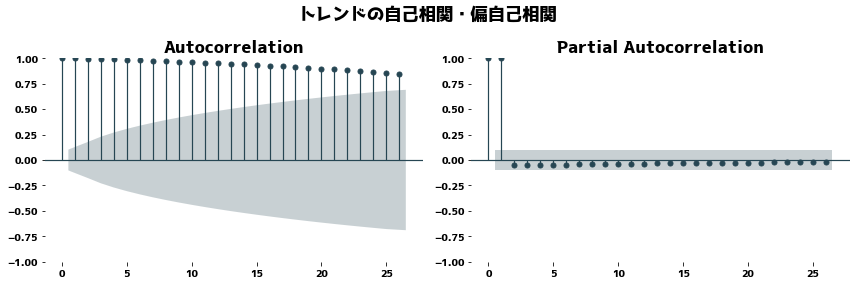

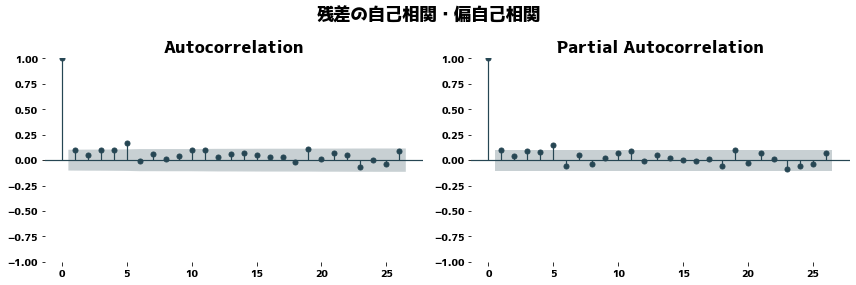

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.suptitle("トレンドの自己相関・偏自己相関")
plot_acf(dr.trend.dropna(), ax=axes[0])
plot_pacf(dr.trend.dropna(), method="ywm", ax=axes[1])
plt.tight_layout()
plt.show()

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.suptitle("残差の自己相関・偏自己相関")
plot_acf(dr.resid.dropna(), ax=axes[0])
plot_pacf(dr.resid.dropna(), method="ywm", ax=axes[1])
plt.tight_layout()
plt.show()

## 残差に対するかばん検定

In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(dr.resid.dropna(), lags=int(np.log(df.shape[0])))

,lb_stat,lb_pvalue
1,3.962297,0.046530
2,4.823514,0.089658
3,8.456753,0.037457
4,12.092893,0.016674
5,23.134467,0.000318


## トレンドを近似する

区分的な線形関数で近似してみます。
コードは[ruoyu0088/segments_fit.ipynb](https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a)のものを使用しています。

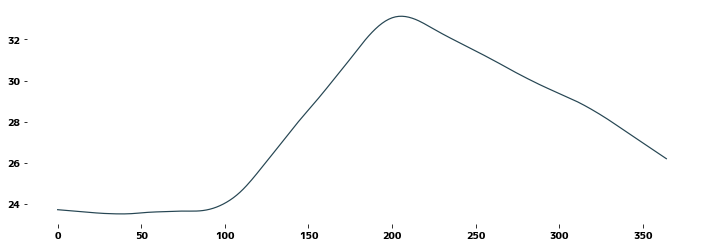

In [11]:
plt.figure(figsize=(12, 4))
trend_data = dr.trend.dropna()
plt.plot(trend_data)
plt.show()

### 区分線形関数
[ruoyu0088/segments_fit.ipynb](https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a)のコードを元にしています。

- [numpy.percentile](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html)
- [scipy.special.huber](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.huber.html)
- [ruoyu0088/segments_fit.ipynb](https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a)

In [12]:
from scipy import optimize
from scipy.special import huber


def segments_fit(X, Y, count, is_use_huber=True, delta=0.5):
    """
    original: https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
    ruoyu0088氏作成の ruoyu0088/segments_fit.ipynb　より引用しています
    """
    xmin = X.min()
    xmax = X.max()
    seg = np.full(count - 1, (xmax - xmin) / count)
    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array(
        [Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init]
    )

    def func(p):
        seg = p[: count - 1]
        py = p[count - 1 :]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        if is_use_huber:
            return np.mean(huber(delta, Y - Y2))
        else:
            return np.mean((Y - Y2) ** 2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method="Nelder-Mead")
    return func(r.x)

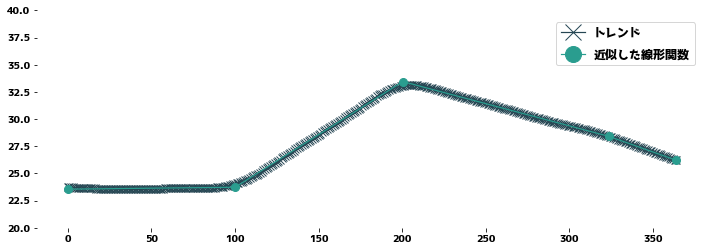

In [13]:
x = np.arange(0, len(trend_data))
y = trend_data

plt.figure(figsize=(12, 4))
px, py = segments_fit(x, y, 4)
plt.plot(x, y, "-x", label="トレンド")
plt.plot(px, py, "-o", label="近似した線形関数")
plt.ylim(20, 40)
plt.legend()

## 元データからトレンドを除去する
### トレンドのみのデータを用意する

In [14]:
trend_data_first, trend_data_last = trend_data.iloc[0], trend_data.iloc[-1]

for i in range(int(period / 2)):
    trend_data[trend_data.index.min() - 1] = trend_data_first
    trend_data[trend_data.index.max() + 1] = trend_data_last

trend_data.sort_index()

-14     23.728925
-13     23.728925
-12     23.728925
-11     23.728925
-10     23.728925
          ...    
 374    26.206443
 375    26.206443
 376    26.206443
 377    26.206443
 378    26.206443
Name: trend, Length: 393, dtype: float64

### トレンドを取り除いた波形を確認する

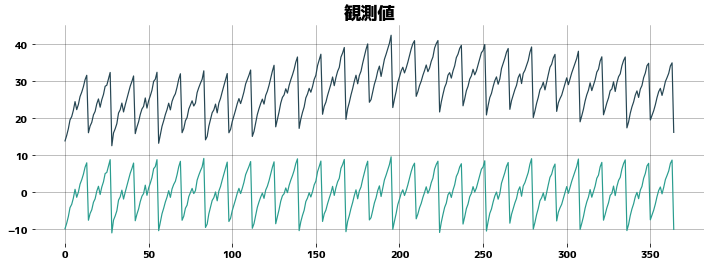

In [15]:
plt.figure(figsize=(12, 4))
plt.title("観測値")
plt.plot(dr.observed, label="トレンドあり")
plt.plot(dr.observed - trend_data, label="トレンド除去済み")
plt.grid()